In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score
import warnings
import os
import time
import ipaddress
from datetime import datetime, timedelta
from collections import defaultdict, Counter
import json
from tqdm.notebook import tqdm
# Import library tambahan untuk geolokasi processing
from collections import defaultdict
import math

print("Libraries untuk geolokasi preprocessing berhasil diimport")

# Abaikan warning yang tidak penting
warnings.filterwarnings('ignore')

# Set tampilan matplotlib
plt.style.use('ggplot')
%matplotlib inline

# Load dataset
# Gunakan dataset yang telah difilter (500 users dengan 200-7000 records)
print("Loading dataset...")
df = pd.read_csv('rba_dataset_filtered100-5000.csv')
print(f"Dataset loaded with shape: {df.shape}")

# Tampilkan beberapa baris pertama untuk memahami struktur data
df.head()

Libraries untuk geolokasi preprocessing berhasil diimport
Loading dataset...
Dataset loaded with shape: (590061, 16)


,index,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,User Agent String,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover
0,8,2020-02-03 12:44:17.474,8076000552587369902,NaN,10.0.61.212,NO,-,-,29695,Mozilla/5.0 (Linux; U; Android 7.1.2; en-gb; R...,MiuiBrowser 12.6.5,Android 7.1.2,mobile,False,False,False
1,10,2020-02-03 12:44:19.260,5932501938287412564,NaN,84.48.61.135,NO,-,-,15659,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 86.0.4202,Mac OS X 10.14.6,desktop,True,False,False
2,15,2020-02-03 12:44:30.475,-8296667206273764769,1123.0,82.147.58.93,NO,Oslo County,Oslo,29492,Mozilla/5.0 (iPad; CPU OS 7_1 like Mac OS X) ...,Android 2.3.3.2672,iOS 7.1,mobile,True,False,False
3,126,2020-02-03 12:46:08.490,-8296667206273764769,573.0,82.147.58.93,NO,Oslo County,Oslo,29492,Mozilla/5.0 (iPad; CPU OS 7_1 like Mac OS X) ...,Android 2.3.3.2672,iOS 7.1,mobile,True,False,False
4,218,2020-02-03 12:47:15.814,-5100889510564409279,NaN,84.48.135.147,NO,Vestland,Florvag,15659,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 69.0.3497.17.19,Mac OS X 10.14.6,desktop,False,False,False


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590061 entries, 0 to 590060
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   index                     590061 non-null  int64  
 1   Login Timestamp           590061 non-null  object 
 2   User ID                   590061 non-null  int64  
 3   Round-Trip Time [ms]      32088 non-null   float64
 4   IP Address                590061 non-null  object 
 5   Country                   590061 non-null  object 
 6   Region                    590061 non-null  object 
 7   City                      590061 non-null  object 
 8   ASN                       590061 non-null  int64  
 9   User Agent String         590061 non-null  object 
 10  Browser Name and Version  590061 non-null  object 
 11  OS Name and Version       590061 non-null  object 
 12  Device Type               590055 non-null  object 
 13  Login Successful          5900

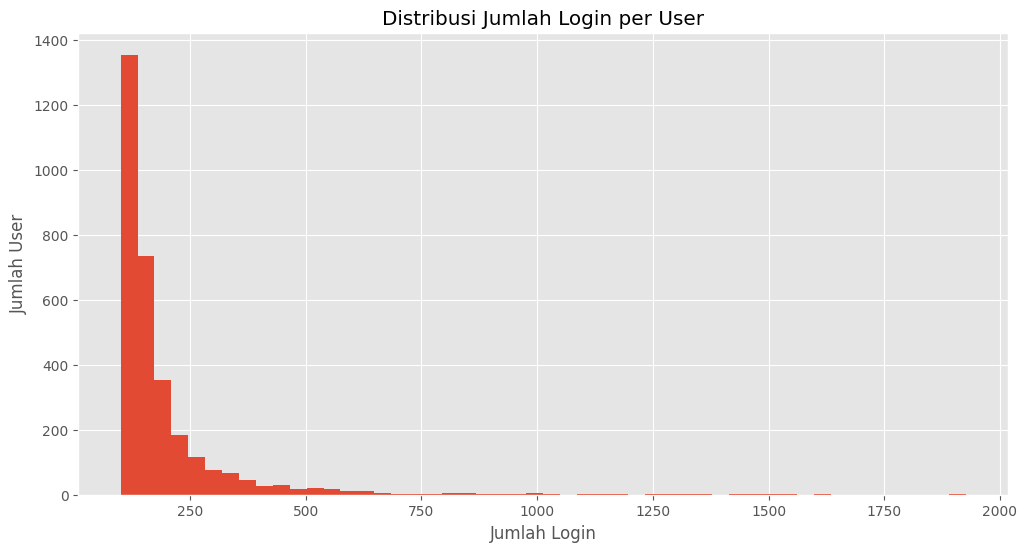


Statistik login per user:
count    3116.000000
mean      189.364891
std       145.473995
min       100.000000
25%       117.000000
50%       145.000000
75%       196.000000
max      1927.000000
Name: count, dtype: float64


In [2]:
# Isi nilai kosong pada kolom 'Region' dan 'City' dengan 'unknown'
df['Region'].fillna('unknown', inplace=True)
df['City'].fillna('unknown', inplace=True)# Eksplorasi informasi dasar dataset


print("Dataset info:")
df.info()

# Statistik deskriptif
print("\nStatistik deskriptif:")
df.describe()


# Cek missing values
print("\nJumlah missing values per kolom:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Cek distribusi label (jika ada)
if 'Is Account Takeover' in df.columns:
    print("\nDistribusi Is Account Takeover:")
    print(df['Is Account Takeover'].value_counts())
    print(f"Persentase anomali: {df['Is Account Takeover'].mean() * 100:.2f}%")

# Cek distribusi label (jika ada)
if 'Is Attack IP' in df.columns:
    print("\nDistribusi Is Attack IP:")
    print(df['Is Attack IP'].value_counts())
    print(f"Persentase anomali: {df['Is Attack IP'].mean() * 100:.2f}%")

# Periksa jumlah unique User IDs
print(f"\nJumlah unique User IDs: {df['User ID'].nunique()}")

# Distribusi data per user
user_counts = df['User ID'].value_counts()
plt.figure(figsize=(12, 6))
plt.hist(user_counts, bins=50)
plt.title('Distribusi Jumlah Login per User')
plt.xlabel('Jumlah Login')
plt.ylabel('Jumlah User')
plt.show()

# Tampilkan statistik dari distribusi login per user
print("\nStatistik login per user:")
print(user_counts.describe())

In [3]:
# Konversi tipe data
def preprocess_basic(df):
    # Buat salinan DataFrame untuk diolah
    processed_df = df.copy()
    
    # Konversi timestamp jika dalam format epoch (integer)
    if pd.api.types.is_integer_dtype(processed_df['Login Timestamp']):
        processed_df['Login Timestamp'] = pd.to_datetime(processed_df['Login Timestamp'], unit='ms')
    else:
        processed_df['Login Timestamp'] = pd.to_datetime(processed_df['Login Timestamp'])
    
    # Tambahkan kolom untuk ekstraksi fitur temporal
    processed_df['Hour'] = processed_df['Login Timestamp'].dt.hour
    processed_df['Day'] = processed_df['Login Timestamp'].dt.dayofweek
    processed_df['Is Working Day'] = processed_df['Day'].apply(lambda x: 0 if x >= 5 else 1)  # 0 untuk weekend, 1 untuk weekday
    
    # Pisahkan OS dan versi dari 'OS Name and Version'
    if 'OS Name and Version' in processed_df.columns:
        processed_df['OS Name'] = processed_df['OS Name and Version'].apply(
            lambda x: x.split(' ')[0] if isinstance(x, str) else np.nan)
    
    # Pisahkan Browser dan versi dari 'Browser Name and Version'
    if 'Browser Name and Version' in processed_df.columns:
        processed_df['Browser Name'] = processed_df['Browser Name and Version'].apply(
            lambda x: x.split(' ')[0] if isinstance(x, str) else np.nan)
    
    # Konversi kolom boolean ke numeric jika diperlukan
    for col in ['Login Successful', 'Is Attack IP', 'Is Account Takeover']:
        if col in processed_df.columns:
            if processed_df[col].dtype == 'object':
                processed_df[col] = processed_df[col].map({'true': 1, 'false': 0, True: 1, False: 0})
    
    return processed_df

# Terapkan preprocessing dasar
preprocessed_df = preprocess_basic(df)
print("Basic preprocessing completed.")
preprocessed_df.head()

Basic preprocessing completed.


,index,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,User Agent String,...,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover,Hour,Day,Is Working Day,OS Name,Browser Name
0,8,2020-02-03 12:44:17.474,8076000552587369902,NaN,10.0.61.212,NO,-,-,29695,Mozilla/5.0 (Linux; U; Android 7.1.2; en-gb; R...,...,Android 7.1.2,mobile,False,False,False,12,0,1,Android,MiuiBrowser
1,10,2020-02-03 12:44:19.260,5932501938287412564,NaN,84.48.61.135,NO,-,-,15659,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,...,Mac OS X 10.14.6,desktop,True,False,False,12,0,1,Mac,Chrome
2,15,2020-02-03 12:44:30.475,-8296667206273764769,1123.0,82.147.58.93,NO,Oslo County,Oslo,29492,Mozilla/5.0 (iPad; CPU OS 7_1 like Mac OS X) ...,...,iOS 7.1,mobile,True,False,False,12,0,1,iOS,Android
3,126,2020-02-03 12:46:08.490,-8296667206273764769,573.0,82.147.58.93,NO,Oslo County,Oslo,29492,Mozilla/5.0 (iPad; CPU OS 7_1 like Mac OS X) ...,...,iOS 7.1,mobile,True,False,False,12,0,1,iOS,Android
4,218,2020-02-03 12:47:15.814,-5100889510564409279,NaN,84.48.135.147,NO,Vestland,Florvag,15659,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,...,Mac OS X 10.14.6,desktop,False,False,False,12,0,1,Mac,Chrome


In [4]:
def calculate_universal_categorical_features(df, user_id_col='User ID', temporal_window=30):
    """
    Menghitung fitur kategorikal universal berdasarkan frekuensi dan similaritas
    
    Args:
        df: DataFrame dengan data login
        user_id_col: Nama kolom untuk user ID
        temporal_window: Jendela waktu (dalam hari) untuk menghitung similaritas
        
    Returns:
        DataFrame dengan fitur kategorikal tambahan
    """
    print("Calculating universal categorical features...")
    result_df = df.copy()
    
    # Fitur kategorikal universal yang akan diproses (tanpa fitur lokasi)
    universal_categorical_features = [
        'OS Name', 'Browser Name', 'Device Type'
    ]
    
    # Pastikan hanya menggunakan fitur yang ada dalam DataFrame
    universal_categorical_features = [f for f in universal_categorical_features if f in df.columns]
    
    # Fungsi untuk menghitung skor similaritas berdasarkan persamaan 3.4.2 dari paper
    def similarity_score(value, user_history):
        if pd.isna(value) or len(user_history) == 0:
            return 0.0
        
        # Hitung bobot setiap nilai dalam histori pengguna
        value_counts = Counter(user_history)
        total_weight = sum(value_counts.values())
        
        # Jika nilai saat ini ada dalam histori, hitung similaritas
        if value in value_counts:
            return value_counts[value] / total_weight
        return 0.0
    
    # DataFrame untuk menyimpan fitur baru
    feature_columns = []
    
    # Proses setiap fitur kategorikal
    for feature in universal_categorical_features:
        print(f"Processing {feature}...")
        
        # Kolom baru untuk menyimpan hasil
        similarity_col = f"{feature}_similarity"
        frequency_col = f"{feature}_Frequency"
        anomaly_col = f"{feature}_anomaly"
        
        feature_columns.extend([similarity_col, frequency_col, anomaly_col])
        result_df[similarity_col] = 0.0
        result_df[frequency_col] = 0.0
        result_df[anomaly_col] = 0.0
        
        # Urutkan berdasarkan user dan timestamp
        sorted_df = result_df.sort_values([user_id_col, 'Login Timestamp'])
        
        # Proses untuk setiap pengguna
        for user in tqdm(sorted_df[user_id_col].unique(), desc=f"Computing {feature} features"):
            user_data = sorted_df[sorted_df[user_id_col] == user].copy()
            
            # Inisialisasi histori pengguna
            user_history = []
            
            # Iterasi melalui login pengguna yang diurutkan berdasarkan waktu
            for idx, row in user_data.iterrows():
                current_value = row[feature]
                current_time = row['Login Timestamp']
                
                # Hitung similaritas dengan historis sebelumnya
                similarity = similarity_score(current_value, user_history)
                result_df.at[idx, similarity_col] = similarity
                
                # Hitung frekuensi relatif
                if len(user_history) > 0:
                    frequency = user_history.count(current_value) / len(user_history) if not pd.isna(current_value) else 0
                    result_df.at[idx, frequency_col] = frequency
                
                # Hitung skor anomali (1 - similaritas) sesuai dengan paper
                result_df.at[idx, anomaly_col] = 1.0 - similarity
                
                # Update histori pengguna jika login berhasil
                if row['Login Successful'] == 1:
                    # Hapus entri lama (lebih dari temporal_window hari)
                    if len(user_history) > 0:
                        cutoff_time = current_time - pd.Timedelta(days=temporal_window)
                        # Untuk implementasi sederhana, kita hanya menambahkan nilai baru
                    
                    # Tambahkan nilai saat ini ke histori
                    if not pd.isna(current_value):
                        user_history.append(current_value)
    
    print("Universal categorical features calculation completed.")
    return result_df, feature_columns

In [5]:
def calculate_cyclic_features(df, user_id_col='User ID'):
    """
    Menghitung fitur siklik seperti Hour dan Day sesuai dengan persamaan 3.4.11 dari paper
    
    Args:
        df: DataFrame dengan data login
        user_id_col: Nama kolom untuk user ID
        
    Returns:
        DataFrame dengan fitur siklik tambahan
    """
    print("Calculating cyclic features...")
    result_df = df.copy()
    
    # Fitur siklik yang akan diproses
    # Sesuai permintaan, hanya fokus pada TimeOfHour dan eliminasi TimeOfDay
    cyclic_features = {
        'Hour': {'period': 24, 'bins': 24}
    }
    
    # DataFrame untuk menyimpan fitur baru
    feature_columns = []
    
    # Proses setiap fitur siklik
    for feature, config in cyclic_features.items():
        print(f"Processing {feature}...")
        
        # Kolom baru untuk menyimpan hasil
        similarity_col = f"TimeOf{feature}_similarity"
        anomaly_col = f"TimeOf{feature}_anomaly"
        
        feature_columns.extend([similarity_col, anomaly_col])
        result_df[similarity_col] = 0.0
        result_df[anomaly_col] = 0.0
        
        # Urutkan berdasarkan user dan timestamp
        sorted_df = result_df.sort_values([user_id_col, 'Login Timestamp'])
        
        # Proses untuk setiap pengguna
        for user in tqdm(sorted_df[user_id_col].unique(), desc=f"Computing {feature} features"):
            user_data = sorted_df[sorted_df[user_id_col] == user].copy()
            
            # Inisialisasi histogram untuk fitur siklik
            histogram = [0] * config['bins']
            
            # Iterasi melalui login pengguna yang diurutkan berdasarkan waktu
            for idx, row in user_data.iterrows():
                current_value = row[feature]
                
                # Konversi ke representasi sudut
                theta_x = 2 * np.pi * current_value / config['period']
                
                # Hitung similaritas berdasarkan histori
                similarity = 0.0
                total_weight = sum(histogram)
                
                if total_weight > 0:
                    weighted_sum = 0.0
                    for i, weight in enumerate(histogram):
                        theta_i = 2 * np.pi * i / config['bins']
                        weighted_sum += weight * np.cos(theta_x - theta_i)
                    
                    # Persamaan 3.4.11 dari paper
                    similarity = 0.5 * (weighted_sum / total_weight + 1)
                
                # Simpan similaritas dan anomali
                result_df.at[idx, similarity_col] = similarity
                result_df.at[idx, anomaly_col] = 1.0 - similarity
                
                # Update histogram jika login berhasil
                if row['Login Successful'] == 1:
                    bin_index = int(current_value * config['bins'] / config['period'])
                    if bin_index >= config['bins']:
                        bin_index = config['bins'] - 1
                    histogram[bin_index] += 1
                    
                    # Terapkan decay factor (α = 0.95) saat pergantian hari
                    if feature == 'Hour' and current_value == 0:
                        histogram = [0.95 * w for w in histogram]
    
    print("Cyclic features calculation completed.")
    return result_df, feature_columns

In [6]:
def calculate_universal_linear_features(df, user_id_col='User ID'):
        """
        Menghitung fitur linear/kuantitatif universal tanpa RTT
        
        Args:
            df: DataFrame dengan data login
            user_id_col: Nama kolom untuk user ID
            
        Returns:
            DataFrame dengan fitur linear tambahan
        """
        print("Calculating universal linear features...")
        result_df = df.copy()
        
        # Tambahkan fitur untuk jumlah login per hari
        result_df['Date'] = result_df['Login Timestamp'].dt.date
        
        # Tambahkan kolom login sukses dan login gagal per user per hari
        daily_logins = result_df.groupby([user_id_col, 'Date']).size().reset_index(name='DailyLoginCount')
        result_df = pd.merge(
            result_df, 
            daily_logins, 
            on=[user_id_col, 'Date'], 
            how='left'
        )
        
        # Tambahkan kolom untuk jumlah login gagal berurutan
        result_df['ConsecutiveFailedLogins'] = 0
        
        # Tambahkan kolom untuk waktu antara login
        result_df['TimeBetweenLogins'] = pd.Timedelta(seconds=0)
        
        # Kolom untuk fitur linear universal (tanpa RTT)
        linear_cols = ['DailyLoginCount', 'TimeBetweenLogins', 'ConsecutiveFailedLogins']
        feature_columns = []
        
        # Buat kolom similaritas dan anomali untuk fitur linear
        for col in linear_cols:
            similarity_col = f"{col}_similarity"
            anomaly_col = f"{col}_anomaly"
            
            feature_columns.extend([similarity_col, anomaly_col])
            result_df[similarity_col] = 0.0
            result_df[anomaly_col] = 0.0
        
        # Urutkan berdasarkan user dan timestamp
        sorted_df = result_df.sort_values([user_id_col, 'Login Timestamp'])
        
        # Untuk setiap pengguna
        for user in tqdm(sorted_df[user_id_col].unique(), desc="Computing linear features"):
            user_data = sorted_df[sorted_df[user_id_col] == user].copy()
            user_data = user_data.sort_values('Login Timestamp')
            
            # Inisialisasi variabel untuk pelacakan
            ema = {}  # Exponential Moving Average
            std_dev = {}  # Standard Deviation
            
            # Inisialisasi pelacakan login gagal berurutan
            failed_count = 0
            
            # Inisialisasi untuk TimeBetweenLogins
            prev_login_time = None
            
            for i, (idx, row) in enumerate(user_data.iterrows()):
                # Hitung waktu antara login
                if prev_login_time is not None:
                    time_diff = (row['Login Timestamp'] - prev_login_time).total_seconds()
                    result_df.at[idx, 'TimeBetweenLogins'] = time_diff
                
                # Update pelacakan login gagal berurutan
                if row['Login Successful'] == 0:
                    failed_count += 1
                else:
                    failed_count = 0
                
                result_df.at[idx, 'ConsecutiveFailedLogins'] = failed_count
                
                # Hitung similaritas untuk setiap fitur linear
                for col in linear_cols:
                    similarity_col = f"{col}_similarity"
                    anomaly_col = f"{col}_anomaly"
                    
                    # Dapatkan nilai saat ini
                    if col == 'TimeBetweenLogins':
                        current_value = time_diff if prev_login_time else 0
                    else:
                        current_value = row[col]
                    
                    # Hitung similaritas menggunakan moving average dan standar deviasi
                    if col not in ema:
                        # Inisialisasi
                        ema[col] = current_value
                        std_dev[col] = 1.0  # Nilai awal untuk std dev
                        similarity = 1.0  # Nilai awal untuk similaritas
                    else:
                        # Hitung similaritas dengan persamaan Gaussian (3.4.5)
                        if std_dev[col] > 0:
                            z_score = (current_value - ema[col]) / std_dev[col]
                            similarity = np.exp(-0.5 * (z_score ** 2))
                        else:
                            similarity = 1.0 if current_value == ema[col] else 0.0
                    
                    # Simpan similaritas dan anomali
                    result_df.at[idx, similarity_col] = similarity
                    result_df.at[idx, anomaly_col] = 1.0 - similarity
                    
                    # Update EMA dan std_dev jika login berhasil
                    if row['Login Successful'] == 1:
                        alpha = 0.1  # Faktor decay
                        ema[col] = alpha * current_value + (1 - alpha) * ema[col]
                        
                        # Update std_dev menggunakan squared difference
                        squared_diff = (current_value - ema[col]) ** 2
                        std_dev[col] = np.sqrt(alpha * squared_diff + (1 - alpha) * (std_dev[col] ** 2))
                
                # Update waktu login sebelumnya
                if row['Login Successful'] == 1:
                    prev_login_time = row['Login Timestamp']
        
        # Gabungkan fitur login gagal - sesuai permintaan untuk menggabungkan
        # ConsecutiveFailedLogins dan UnsuccessfulLogin menjadi satu fitur
        N = 5  # Threshold untuk login gagal
        result_df['FailedLogin_combined_anomaly'] = result_df['ConsecutiveFailedLogins'].apply(
            lambda x: 1.0 - max(0, 1 - x/N)
        )
        feature_columns.append('FailedLogin_combined_anomaly')
        
        
        print("Universal linear features calculation completed.")
        return result_df, feature_columns

In [7]:
# Terapkan perhitungan untuk fitur siklik
categorical_df, categorical_features = calculate_universal_categorical_features(preprocessed_df)
print(f"Added {len(categorical_features)} new universal categorical features.")

# Terapkan perhitungan untuk fitur siklik
cyclic_df, cyclic_features = calculate_cyclic_features(categorical_df)
print(f"Added {len(cyclic_features)} new cyclic features.")

# Terapkan perhitungan untuk fitur linear universal
linear_df, linear_features = calculate_universal_linear_features(cyclic_df)
print(f"Added {len(linear_features)} new universal linear features.")

# Tampilkan hasil
linear_df.head()

Calculating universal categorical features...
Processing OS Name...


Computing OS Name features:   0%|          | 0/3116 [00:00<?, ?it/s]

Processing Browser Name...


Computing Browser Name features:   0%|          | 0/3116 [00:00<?, ?it/s]

Processing Device Type...


Computing Device Type features:   0%|          | 0/3116 [00:00<?, ?it/s]

Universal categorical features calculation completed.
Added 9 new universal categorical features.
Calculating cyclic features...
Processing Hour...


Computing Hour features:   0%|          | 0/3116 [00:00<?, ?it/s]

Cyclic features calculation completed.
Added 2 new cyclic features.
Calculating universal linear features...


Computing linear features:   0%|          | 0/3116 [00:00<?, ?it/s]

Universal linear features calculation completed.
Added 7 new universal linear features.


,index,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,User Agent String,...,DailyLoginCount,ConsecutiveFailedLogins,TimeBetweenLogins,DailyLoginCount_similarity,DailyLoginCount_anomaly,TimeBetweenLogins_similarity,TimeBetweenLogins_anomaly,ConsecutiveFailedLogins_similarity,ConsecutiveFailedLogins_anomaly,FailedLogin_combined_anomaly
0,8,2020-02-03 12:44:17.474,8076000552587369902,NaN,10.0.61.212,NO,-,-,29695,Mozilla/5.0 (Linux; U; Android 7.1.2; en-gb; R...,...,7,1,0 days 00:00:00,1.0,0.0,1.0,0.0,1.0,0.0,0.2
1,10,2020-02-03 12:44:19.260,5932501938287412564,NaN,84.48.61.135,NO,-,-,15659,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,...,1,0,0 days 00:00:00,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,15,2020-02-03 12:44:30.475,-8296667206273764769,1123.0,82.147.58.93,NO,Oslo County,Oslo,29492,Mozilla/5.0 (iPad; CPU OS 7_1 like Mac OS X) ...,...,6,0,0 days 00:00:00,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,126,2020-02-03 12:46:08.490,-8296667206273764769,573.0,82.147.58.93,NO,Oslo County,Oslo,29492,Mozilla/5.0 (iPad; CPU OS 7_1 like Mac OS X) ...,...,6,0,98.015,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,218,2020-02-03 12:47:15.814,-5100889510564409279,NaN,84.48.135.147,NO,Vestland,Florvag,15659,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,...,5,1,0 days 00:00:00,1.0,0.0,1.0,0.0,1.0,0.0,0.2


In [8]:
def calculate_geolocation_features(df, user_id_col='User ID', temporal_window=30):
    """
    Menghitung fitur geolokasi anomali berdasarkan 2 komponen terpilih:
    G4: asn_new - 0 bila ASN pernah dipakai, 1 jika belum
    G5: location_volatility_10 - (#perpindahan region ≠ sebelumnya dlm 10 login) / 10
    
    Args:
        df: DataFrame dengan data login
        user_id_col: Nama kolom untuk user ID
        temporal_window: Jendela waktu (dalam hari) untuk decay
        
    Returns:
        DataFrame dengan fitur geolokasi anomali tambahan
    """
    print("Calculating geolocation anomaly features (G4 and G5 only)...")
    result_df = df.copy()
    
    # Inisialisasi kolom hasil - hanya untuk G4 dan G5
    result_df['G4_asn_new'] = 0.0
    result_df['G5_location_volatility_10'] = 0.0
    result_df['Geolocation_Anomaly'] = 0.0
    
    # Urutkan berdasarkan user dan timestamp
    sorted_df = result_df.sort_values([user_id_col, 'Login Timestamp'])
    
    # Dictionary untuk menyimpan histori per user - hanya yang diperlukan
    user_histories = defaultdict(lambda: {
        'asn_set': set(),          # Untuk G4
        'last_regions': []         # Untuk G5
    })
    
    # Proses untuk setiap pengguna
    for user in tqdm(sorted_df[user_id_col].unique(), desc="Computing geolocation features (G4,G5)"):
        user_data = sorted_df[sorted_df[user_id_col] == user].copy()
        user_history = user_histories[user]
        
        # Iterasi melalui login pengguna yang diurutkan berdasarkan waktu
        for idx, row in user_data.iterrows():
            current_region = str(row['Region']).strip()
            current_asn = int(row['ASN']) if pd.notna(row['ASN']) else 0
            
            # Handle missing values untuk region
            if current_region in ['-', 'nan', '']:
                current_region = 'Unknown'
            
            # Hitung G4: asn_new
            g4_score = 0.0 if current_asn in user_history['asn_set'] else 1.0
            
            # Hitung G5: location_volatility_10
            recent_regions = user_history['last_regions'][-10:] if len(user_history['last_regions']) > 0 else []
            if len(recent_regions) > 0:
                # Hitung perpindahan region yang berbeda
                changes = 0
                for i in range(len(recent_regions)):
                    if recent_regions[i] != current_region:
                        changes += 1
                g5_score = min(changes / 10.0, 1.0)
            else:
                g5_score = 0.0
            
            # Simpan hasil - hanya G4 dan G5
            result_df.at[idx, 'G4_asn_new'] = g4_score
            result_df.at[idx, 'G5_location_volatility_10'] = g5_score
            
            # Hitung skor anomali gabungan dengan 2 fitur terpilih
            # Bobot optimal: G4=0.60 (dominan), G5=0.40
            geolocation_anomaly = (
                0.60 * g4_score +   # ASN new (bobot tertinggi)
                0.40 * g5_score     # Location volatility
            )
            result_df.at[idx, 'Geolocation_Anomaly'] = geolocation_anomaly
            
            # Update histori hanya jika login berhasil
            if row['Login Successful'] == 1:
                # Update ASN set untuk G4
                user_history['asn_set'].add(current_asn)
                
                # Update last_regions untuk G5
                user_history['last_regions'].append(current_region)
                if len(user_history['last_regions']) > 10:
                    user_history['last_regions'] = user_history['last_regions'][-10:]
    
    print("Geolocation anomaly features calculation completed.")
    return result_df, ['G4_asn_new', 'G5_location_volatility_10', 'Geolocation_Anomaly']

print("Fungsi geolocation features (G4 dan G5) berhasil didefinisikan")

Fungsi geolocation features (G4 dan G5) berhasil didefinisikan


In [9]:
# Terapkan perhitungan untuk fitur geolokasi
geolocation_df, geolocation_features = calculate_geolocation_features(linear_df)
print(f"Added {len(geolocation_features)} new geolocation features.")

# Tampilkan statistik fitur geolokasi
print("\nStatistik fitur geolokasi:")
for feature in geolocation_features:
    if feature in geolocation_df.columns:
        print(f"{feature}:")
        print(f"  Mean: {geolocation_df[feature].mean():.4f}")
        print(f"  Std: {geolocation_df[feature].std():.4f}")
        print(f"  Min: {geolocation_df[feature].min():.4f}")
        print(f"  Max: {geolocation_df[feature].max():.4f}")
        print()

# Tampilkan hasil
geolocation_df.head()

Calculating geolocation anomaly features (G4 and G5 only)...


Computing geolocation features (G4,G5):   0%|          | 0/3116 [00:00<?, ?it/s]

Geolocation anomaly features calculation completed.
Added 3 new geolocation features.

Statistik fitur geolokasi:
G4_asn_new:
  Mean: 0.0283
  Std: 0.1658
  Min: 0.0000
  Max: 1.0000

G5_location_volatility_10:
  Mean: 0.2896
  Std: 0.3537
  Min: 0.0000
  Max: 1.0000

Geolocation_Anomaly:
  Mean: 0.1328
  Std: 0.1707
  Min: 0.0000
  Max: 1.0000



,index,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,User Agent String,...,DailyLoginCount_similarity,DailyLoginCount_anomaly,TimeBetweenLogins_similarity,TimeBetweenLogins_anomaly,ConsecutiveFailedLogins_similarity,ConsecutiveFailedLogins_anomaly,FailedLogin_combined_anomaly,G4_asn_new,G5_location_volatility_10,Geolocation_Anomaly
0,8,2020-02-03 12:44:17.474,8076000552587369902,NaN,10.0.61.212,NO,-,-,29695,Mozilla/5.0 (Linux; U; Android 7.1.2; en-gb; R...,...,1.0,0.0,1.0,0.0,1.0,0.0,0.2,1.0,0.0,0.6
1,10,2020-02-03 12:44:19.260,5932501938287412564,NaN,84.48.61.135,NO,-,-,15659,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.6
2,15,2020-02-03 12:44:30.475,-8296667206273764769,1123.0,82.147.58.93,NO,Oslo County,Oslo,29492,Mozilla/5.0 (iPad; CPU OS 7_1 like Mac OS X) ...,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.6
3,126,2020-02-03 12:46:08.490,-8296667206273764769,573.0,82.147.58.93,NO,Oslo County,Oslo,29492,Mozilla/5.0 (iPad; CPU OS 7_1 like Mac OS X) ...,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,218,2020-02-03 12:47:15.814,-5100889510564409279,NaN,84.48.135.147,NO,Vestland,Florvag,15659,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,...,1.0,0.0,1.0,0.0,1.0,0.0,0.2,1.0,0.0,0.6


In [10]:
def calculate_risk_score_and_prepare_ml_data_universal(df):
    """
    Menghitung skor risiko berdasarkan fitur-fitur anomali universal dan menyiapkan data untuk model ML
    
    Args:
        df: DataFrame dengan fitur anomali
    
    Returns:
        result_df: DataFrame dengan skor risiko dan level risiko
        X: Fitur untuk model
        y_true: Label ground truth berdasarkan threshold
        threshold_info: Informasi threshold yang digunakan
    """
    print("Calculating risk scores and preparing ML data with universal features only...")
    result_df = df.copy()
    
    # Daftar fitur anomali universal - sudah disesuaikan sesuai permintaan
    universal_anomaly_columns = [
        'OS Name_anomaly', 
        'Browser Name_anomaly', 
        'Device Type_anomaly',
        'TimeOfHour_anomaly',         # Gunakan ini ketimbang TimeOfDay
        'DailyLoginCount_anomaly',
        'TimeBetweenLogins_anomaly',
        #'ConsecutiveFailedLogins_anomaly',
        'FailedLogin_combined_anomaly', # Gabungan dari ConsecutiveFailedLogins dan UnsuccessfulLogin
        'Geolocation_Anomaly'     
    ]
    
    # Filter fitur yang ada dalam DataFrame
    universal_features = [col for col in universal_anomaly_columns if col in result_df.columns]
    
    print(f"Using {len(universal_features)} universal anomaly features for risk calculation")
    print("Universal features used:")
    for feature in universal_features:
        print(f"- {feature}")
    
    # Hitung weighted anomaly score berdasarkan fitur universal
    result_df['mean_anomaly_score'] = result_df[universal_features].mean(axis=1)
    
    # Cetak distribusi mean anomaly score
    plt.figure(figsize=(10, 6))
    plt.hist(result_df['mean_anomaly_score'], bins=50)
    plt.title('Distribusi Mean Anomaly Score')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frekuensi')
        # Tambahkan baris ini untuk menyimpan gambar
    plt.savefig('distribusi_anomaly_score.png')
    plt.show()
    

    
    # Menentukan threshold untuk risk level sesuai dengan persamaan 3.5.3 dari paper
    # Menggunakan median dan MAD untuk threshold bawah
    robust_mean = result_df['mean_anomaly_score'].median()  # Sebagai pengganti robust mean
    mad = np.median(np.abs(result_df['mean_anomaly_score'] - robust_mean))  # Median Absolute Deviation
    
    # Hitung threshold bawah
    lower_threshold = robust_mean + 1.5 * mad
    
    # Hitung tail data (nilai di atas threshold bawah)
    tail_data = result_df[result_df['mean_anomaly_score'] > lower_threshold]['mean_anomaly_score'] - lower_threshold
    
    # Gunakan K-means dengan k=2 untuk menentukan threshold atas
    # Untuk sederhananya, kita gunakan persentil 90 dari tail data
    if len(tail_data) > 0:
        upper_threshold = lower_threshold + np.percentile(tail_data, 90)
    else:
        upper_threshold = lower_threshold + 0.1  # Default jika tidak ada tail data
    
    # Simpan informasi threshold untuk referensi
    threshold_info = {
        'robust_mean': robust_mean,
        'mad': mad,
        'lower_threshold': lower_threshold,
        'upper_threshold': upper_threshold
    }
    
    # Cetak informasi threshold
    print(f"Threshold information:")
    print(f"Robust Mean: {robust_mean:.4f}")
    print(f"MAD: {mad:.4f}")
    print(f"Lower Threshold (0 to 1): {lower_threshold:.4f}")
    print(f"Upper Threshold (1 to 2): {upper_threshold:.4f}")
    
    # Simpan informasi threshold ke file
    with open('threshold_info_universal.json', 'w') as f:
        json.dump(threshold_info, f, indent=4)
    
    # Tentukan risk level sesuai dengan persamaan 3.5.3 dari paper
    def determine_risk_level(score):
        if score <= lower_threshold:
            return 0  # Normal (no risk)
        elif score <= upper_threshold:
            return 1  # Medium risk
        else:
            return 2  # High risk
    
    result_df['risk_level'] = result_df['mean_anomaly_score'].apply(determine_risk_level)
    
    # Cetak distribusi risk level
    plt.figure(figsize=(8, 6))
    risk_counts = result_df['risk_level'].value_counts().sort_index()
    plt.bar(risk_counts.index, risk_counts.values)
    plt.title('Distribusi Risk Level')
    plt.xlabel('Risk Level')
    plt.ylabel('Jumlah')
    plt.xticks([0, 1, 2], ['Normal (0)', 'Medium (1)', 'High (2)'])
    for i, count in enumerate(risk_counts.values):
        plt.text(i, count, f"{count}", ha='center', va='bottom')
    plt.savefig('distribusi_risk_level.png')
    plt.show()
    
    # Tampilkan persentase untuk setiap level risiko
    risk_percent = result_df['risk_level'].value_counts(normalize=True).sort_index() * 100
    print("\nDistribusi Risk Level:")
    for level, percent in risk_percent.items():
        print(f"Risk Level {level}: {percent:.2f}%")

    # ----- Persiapan Data untuk Machine Learning -----
    print("\nPreparing data for machine learning...")
    
    # Siapkan fitur
    X = result_df[universal_features]
    
    # Sesuai dengan paper referensi, ground truth dibuat berdasarkan threshold yang dihitung
    # Gunakan risk_level > 0 sebagai threshold untuk anomali
    y_true = result_df['risk_level'] > 0
    print("Following reference paper approach: using 'risk_level > 0' as ground truth for anomaly detection")
    print(f"Distribution of ground truth (0=normal, 1=anomaly): {y_true.value_counts()}")
    print(f"Proportion of anomalies: {y_true.mean():.4f} ({y_true.sum()} out of {len(y_true)})")
    
    return result_df, X, y_true, threshold_info, universal_features

Calculating risk scores and preparing ML data with universal features only...
Using 8 universal anomaly features for risk calculation
Universal features used:
- OS Name_anomaly
- Browser Name_anomaly
- Device Type_anomaly
- TimeOfHour_anomaly
- DailyLoginCount_anomaly
- TimeBetweenLogins_anomaly
- FailedLogin_combined_anomaly
- Geolocation_Anomaly


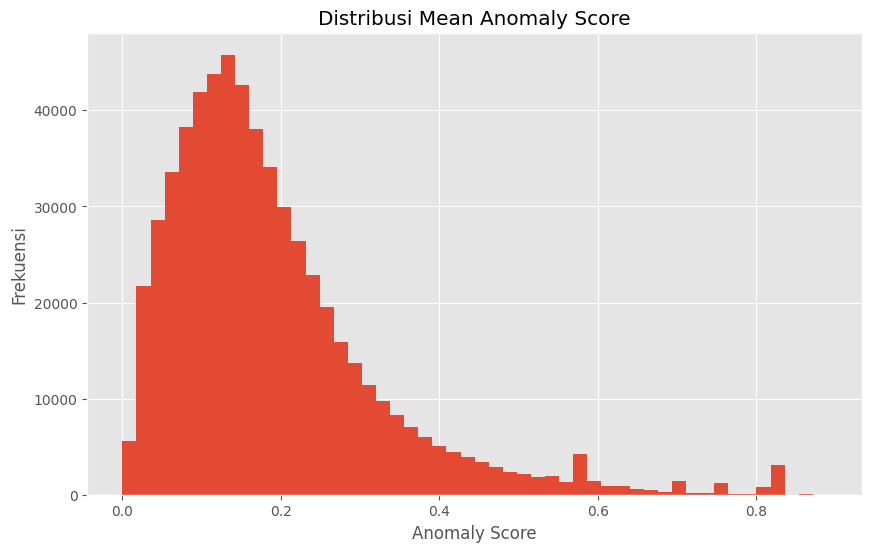

Threshold information:
Robust Mean: 0.1570
MAD: 0.0684
Lower Threshold (0 to 1): 0.2595
Upper Threshold (1 to 2): 0.5750


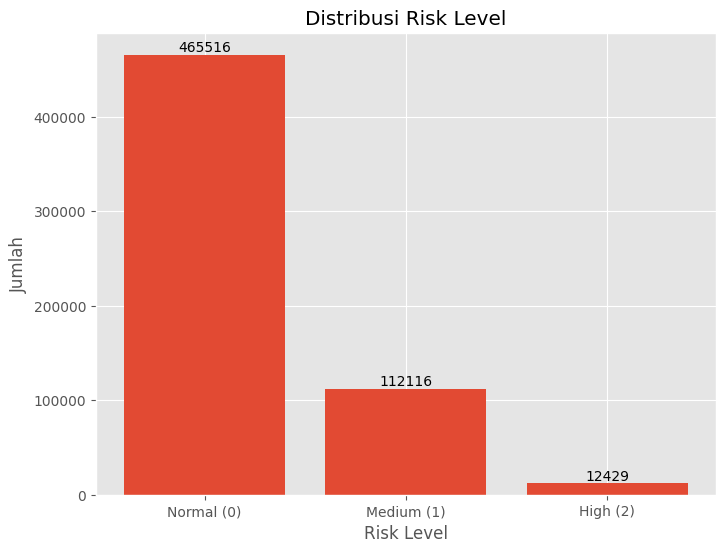


Distribusi Risk Level:
Risk Level 0: 78.89%
Risk Level 1: 19.00%
Risk Level 2: 2.11%

Preparing data for machine learning...
Following reference paper approach: using 'risk_level > 0' as ground truth for anomaly detection
Distribution of ground truth (0=normal, 1=anomaly): risk_level
False    465516
True     124545
Name: count, dtype: int64
Proportion of anomalies: 0.2111 (124545 out of 590061)


,index,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,User Agent String,...,TimeBetweenLogins_similarity,TimeBetweenLogins_anomaly,ConsecutiveFailedLogins_similarity,ConsecutiveFailedLogins_anomaly,FailedLogin_combined_anomaly,G4_asn_new,G5_location_volatility_10,Geolocation_Anomaly,mean_anomaly_score,risk_level
0,8,2020-02-03 12:44:17.474,8076000552587369902,NaN,10.0.61.212,NO,-,-,29695,Mozilla/5.0 (Linux; U; Android 7.1.2; en-gb; R...,...,1.0,0.0,1.0,0.0,0.2,1.0,0.0,0.6,0.600,2
1,10,2020-02-03 12:44:19.260,5932501938287412564,NaN,84.48.61.135,NO,-,-,15659,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.6,0.575,1
2,15,2020-02-03 12:44:30.475,-8296667206273764769,1123.0,82.147.58.93,NO,Oslo County,Oslo,29492,Mozilla/5.0 (iPad; CPU OS 7_1 like Mac OS X) ...,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.6,0.575,1
3,126,2020-02-03 12:46:08.490,-8296667206273764769,573.0,82.147.58.93,NO,Oslo County,Oslo,29492,Mozilla/5.0 (iPad; CPU OS 7_1 like Mac OS X) ...,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.125,0
4,218,2020-02-03 12:47:15.814,-5100889510564409279,NaN,84.48.135.147,NO,Vestland,Florvag,15659,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,...,1.0,0.0,1.0,0.0,0.2,1.0,0.0,0.6,0.600,2


In [11]:
# Terapkan perhitungan risk score dan persiapan data ML dengan fitur universal yang telah disesuaikan
risk_df, X, y_true, thresholds, universal_features = calculate_risk_score_and_prepare_ml_data_universal(geolocation_df)

# Simpan informasi fitur untuk referensi
feature_info = {
    'categorical_features': [f for f in categorical_features if any(feature in f for feature in ['OS Name', 'Browser Name', 'Device Type'])],
    'cyclic_features': cyclic_features,
    'linear_features': linear_features,
    'geolocation_features': geolocation_features,  # Tambahan
    'universal_anomaly_columns': universal_features
}

with open('feature_info_universal.json', 'w') as f:
    json.dump(feature_info, f, indent=4)

# Tampilkan hasil
risk_df.head()

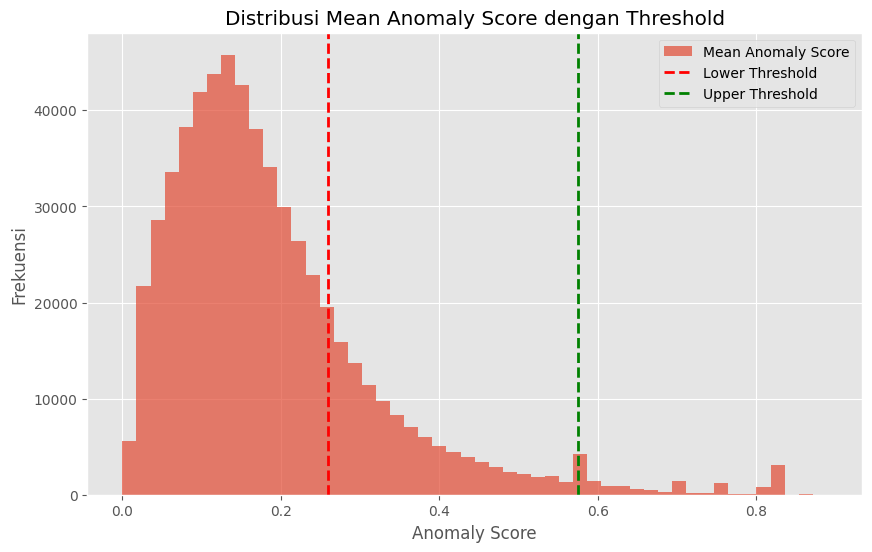

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(risk_df['mean_anomaly_score'], bins=50, alpha=0.7, label='Mean Anomaly Score')

plt.axvline(x=thresholds['lower_threshold'], color='red', linestyle='--', linewidth=2, label='Lower Threshold')
plt.axvline(x=thresholds['upper_threshold'], color='green', linestyle='--', linewidth=2, label='Upper Threshold')

plt.title('Distribusi Mean Anomaly Score dengan Threshold')
plt.xlabel('Anomaly Score')
plt.ylabel('Frekuensi')

plt.legend()
plt.savefig('distribusi_anomaly_score_with_threshold.png')
plt.show()


In [13]:
# ---------------------------------
# Ringkasan statistik kolom mean_anomaly_score
# ---------------------------------
s = risk_df['mean_anomaly_score'].dropna()

mean_global   = s.mean()          # rata-rata aritmetika seluruh baris
median_global = s.median()        # kuantil 50 %
mad_global    = np.median(np.abs(s - median_global))
std_global    = s.std(ddof=0)     # bonus: simpangan baku biasa

print(f"Mean  (μ)  : {mean_global:.6f}")
print(f"Median(𝑥̃) : {median_global:.6f}")
print(f"MAD        : {mad_global:.6f}")
print(f"Std. Dev σ : {std_global:.6f}")


Mean  (μ)  : 0.188501
Median(𝑥̃) : 0.157009
MAD        : 0.068358
Std. Dev σ : 0.135392


In [12]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

print("Splitting data into train/test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_true, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_true
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Training anomaly rate: {y_train.mean():.4f}")
print(f"Testing anomaly rate: {y_test.mean():.4f}")

# Now you can call your function

Splitting data into train/test sets...
Training set size: 472048 samples
Testing set size: 118013 samples
Training anomaly rate: 0.2111
Testing anomaly rate: 0.2111


In [ ]:
# Filter data yang dianggap "normal"
normal_data = risk_df[risk_df['risk_level'] == 2]

# Ambil 10 contoh acak (dengan seed tetap agar bisa direproduksi)
sample_normal = normal_data.sample(n=10, random_state=42)

# Tampilkan
print("10 Data Training Normal (Risk Level 0):")
display(sample_normal)

# Jika ingin hanya fitur-fitur universal:
universal_columns = [
    'OS Name_anomaly', 
    'Browser Name_anomaly', 
    'Device Type_anomaly',
    'TimeOfHour_anomaly',         
    'DailyLoginCount_anomaly',
    'TimeBetweenLogins_anomaly',
    'FailedLogin_combined_anomaly',
    'Geolocation_Anomaly'
]

# Pastikan kolom-kolom ini ada
universal_columns = [col for col in universal_columns if col in sample_normal.columns]

# Tampilkan hanya fitur untuk model
sample_features = sample_normal[universal_columns]
print("Fitur-fitur anomali dari 10 data normal:")
display(sample_features)


10 Data Training Normal (Risk Level 0):


,index,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,User Agent String,...,TimeBetweenLogins_similarity,TimeBetweenLogins_anomaly,ConsecutiveFailedLogins_similarity,ConsecutiveFailedLogins_anomaly,FailedLogin_combined_anomaly,G4_asn_new,G5_location_volatility_10,Geolocation_Anomaly,mean_anomaly_score,risk_level
576602,30388974,2021-02-17 15:00:00.644,-3598888893085517075,NaN,92.220.168.88,NO,Vestland,Bergen,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 12_5_4 like...,...,6.536406e-01,0.346359,1.0,0.0,0.0,0.0,1.0,0.40,0.579938,2
382366,18717235,2020-10-20 06:19:14.727,7424663990268499989,NaN,89.162.75.100,NO,Nordland,Bodø,29695,Mozilla/5.0 (Linux; Android 5.0; SAMSUNG SM-G...,...,7.633167e-27,1.000000,1.0,0.0,1.0,0.0,1.0,0.40,0.765214,2
496794,25400766,2020-12-27 13:36:17.690,-745458258143514699,NaN,84.210.61.237,NO,Viken,Sarpsborg,41164,Mozilla/5.0 (x86_64) AppleWebKit/533.1 (KHTML...,...,1.000000e+00,0.000000,1.0,0.0,1.0,1.0,0.0,0.60,0.749184,2
585820,30930586,2021-02-24 18:37:33.210,5735544635778420566,485.0,84.208.83.215,NO,Oslo County,Oslo,41164,Mozilla/5.0 (iPod; CPU iPhone OS 6_1_6 like Ma...,...,5.405670e-04,0.999459,1.0,0.0,0.2,0.0,0.9,0.36,0.763275,2
560216,29564864,2021-02-07 04:41:38.076,-8214869298499564443,NaN,109.247.228.98,NO,Vestfold og Telemark,Langangen,29695,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,...,4.099765e-01,0.590023,1.0,0.0,0.4,0.0,0.1,0.04,0.665143,2
64674,3392467,2020-03-20 15:32:50.941,6424191589311906749,NaN,84.48.214.75,NO,Viken,Drobak,15659,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_...,...,3.990980e-42,1.000000,1.0,0.0,0.0,1.0,1.0,1.00,0.660550,2
184062,9482360,2020-06-14 16:05:40.320,-3550173317628772375,NaN,170.39.79.86,US,-,-,393398,Mozilla/5.0 (Linux; Android 4.1; Galaxy Nexus...,...,1.000000e+00,0.000000,1.0,0.0,1.0,1.0,0.0,0.60,0.825000,2
25999,1483781,2020-02-23 03:57:16.619,-4434114789166712142,NaN,10.0.76.222,NO,-,-,29695,Mozilla/5.0 (Android 6.0.99; Tablet; https://...,...,1.000000e+00,0.000000,1.0,0.0,1.0,1.0,0.0,0.60,0.825000,2
569325,29980131,2021-02-12 08:13:06.343,-8897190181838729192,NaN,84.208.244.73,NO,Rogaland,Royneberg,41164,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,...,0.000000e+00,1.000000,1.0,0.0,1.0,0.0,0.4,0.16,0.612881,2
326433,16228104,2020-09-16 05:30:17.903,-8897190181838729192,NaN,84.208.244.73,NO,Rogaland,Royneberg,41164,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,...,0.000000e+00,1.000000,1.0,0.0,1.0,0.0,0.4,0.16,0.626694,2


Fitur-fitur anomali dari 10 data normal:


,OS Name_anomaly,Browser Name_anomaly,Device Type_anomaly,TimeOfHour_anomaly,DailyLoginCount_anomaly,TimeBetweenLogins_anomaly,FailedLogin_combined_anomaly,Geolocation_Anomaly
576602,0.991453,1.000000,0.854701,0.331053,0.715942,0.346359,0.0,0.40
382366,0.800000,0.800000,0.700000,0.421709,1.000000,1.000000,1.0,0.40
496794,1.000000,1.000000,1.000000,1.000000,0.393469,0.000000,1.0,0.60
585820,1.000000,1.000000,1.000000,0.546743,1.000000,0.999459,0.2,0.36
560216,0.936170,0.936170,0.936170,0.664171,0.818439,0.590023,0.4,0.04
64674,1.000000,0.957746,0.957746,0.252504,0.116405,1.000000,0.0,1.00
184062,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.60
25999,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.60
569325,0.000000,0.500000,0.500000,0.750000,0.993051,1.000000,1.0,0.16
326433,0.000000,0.500000,0.500000,0.853553,1.000000,1.000000,1.0,0.16


In [ ]:
def train_evaluate_isolation_forest_universal(X_train, y_train, X_test, y_test, contamination=None, save_model=True):
    """
    Melatih model Isolation Forest dengan fitur universal menggunakan pipeline,
    mengevaluasi performa, dan menyimpannya
    
    Args:
        X_train: Fitur data training
        X_test: Fitur data testing
        y_test: Label sebenarnya untuk data testing
        contamination: Perkiraan proporsi anomali dalam dataset
        save_model: Boolean untuk menyimpan model
        
    Returns:
        pipeline: Pipeline dengan StandardScaler dan Isolation Forest
        metrics: Dictionary berisi metrik evaluasi
    """
    import pickle
    import os
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline
    
    print("Training Isolation Forest model with universal features...")
    
    # Tentukan contamination jika tidak ditentukan
    if contamination is None:
        contamination = y_train.mean()
    
    # Buat dan latih pipeline
    start_time = time.time()
    pipe = make_pipeline(
        StandardScaler(),
        IsolationForest(
            n_estimators=200,
            max_samples='auto',
            max_features=0.8,
            contamination=contamination,
            random_state=42,
            n_jobs=-1
        )
    )
    pipe.fit(X_train)
    training_time = time.time() - start_time
    
    # Prediksi pada data testing
    start_time = time.time()
    y_pred = pipe.predict(X_test)
    y_pred = np.where(y_pred == -1, 1, 0)  # Konversi -1 (outlier) menjadi 1 (anomali)
    
    # Hitung skor anomali dan simpan rentang untuk normalisasi
    raw_train_scores = -pipe.decision_function(X_train)
    raw_test_scores = -pipe.decision_function(X_test)
    score_min, score_max = float(raw_train_scores.min()), float(raw_train_scores.max())
    
    # Normalisasi skor test untuk evaluasi
    anomaly_scores = (raw_test_scores - score_min) / (score_max - score_min)
    prediction_time = time.time() - start_time
    
    # Evaluasi model
    metrics = evaluate_model(y_test, y_pred, anomaly_scores)
    metrics['training_time'] = training_time
    metrics['prediction_time'] = prediction_time
    
    # Simpan model jika diminta
    if save_model:
        model_filename = f'rba_universal_isolation_{metrics["f1_score_macro"]:.4f}.pkl'
        print(f"Saving pipeline to {model_filename}...")
        
        # Simpan pipeline dan informasi scoring
        model_data = {
            'pipeline': pipe,
            'features': X_train.columns.tolist(),
            'metrics': metrics,
            'thresholds': thresholds,
            'score_min': score_min,
            'score_max': score_max,
            'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        
        with open(model_filename, 'wb') as file:
            pickle.dump(model_data, file)
        
        print(f"Pipeline dan scoring info berhasil disimpan!")
        
        # Update informasi di file text
        model_info_filename = f'rba_universal_isolation_{metrics["f1_score_macro"]:.4f}_info.txt'
        
        with open(model_info_filename, 'w') as file:
            file.write("=== INFORMATION ISOLATION FOREST MODEL (UNIVERSAL FEATURES) ===\n\n")
            file.write(f"Model Name: Isolation Forest for Risk-Based Authentication with Universal Features\n")
            file.write(f"Training Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            file.write(f"Number of Features: {X_train.shape[1]}\n")
            file.write("Pipeline Components: StandardScaler + IsolationForest\n\n")
            
            file.write("Performance Metrics:\n")
            file.write(f"F1-Score (Macro): {metrics['f1_score_macro']:.4f}\n")
            file.write(f"ROC AUC: {metrics['roc_auc']:.4f}\n")
            file.write(f"Training Time: {metrics['training_time']:.2f} seconds\n")
            file.write(f"Prediction Time: {metrics['prediction_time']:.2f} seconds\n\n")
            
            file.write("Model Parameters:\n")
            for name, estimator in pipe.named_steps.items():
                file.write(f"\n{name} parameters:\n")
                for param, value in estimator.get_params().items():
                    file.write(f"- {param}: {value}\n")
            
            file.write("\nFeatures Used (Universal Only):\n")
            for feature in X_train.columns:
                file.write(f"- {feature}\n")
            
            file.write("\nScoring Information:\n")
            file.write(f"Score Min: {score_min:.4f}\n")
            file.write(f"Score Max: {score_max:.4f}\n")
            
            file.write("\nThreshold Information:\n")
            for key, value in thresholds.items():
                file.write(f"{key}: {value:.4f}\n")
            
        print(f"Model information saved to {model_info_filename}")
    
    return pipe, metrics

def evaluate_model(y_true, y_pred, anomaly_scores):
    """
    Mengevaluasi performa model anomaly detection
    
    Args:
        y_true: Label sebenarnya
        y_pred: Prediksi label (0 untuk normal, 1 untuk anomali)
        anomaly_scores: Skor anomali (nilai tinggi untuk anomali)
        
    Returns:
        Dictionary berisi metrik evaluasi
    """
    # Hitung metrik
    f1 = f1_score(y_true, y_pred, average='macro')
    
    # Hitung ROC AUC (jika label biner)
    try:
        roc_auc = roc_auc_score(y_true, anomaly_scores)
    except:
        roc_auc = 0.5  # Nilai default jika tidak dapat menghitung ROC AUC
    
    # Tampilkan classification report
    print(classification_report(y_true, y_pred))
    
    # Tampilkan confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Isolation Forest')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Tampilkan ROC curve
    if hasattr(y_true, 'nunique') and y_true.nunique() == 2:
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(y_true, anomaly_scores)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) - Isolation Forest')
        plt.legend(loc="lower right")
        plt.show()
    
    return {
        'f1_score_macro': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }


===== Evaluasi Model Isolation Forest =====
Training Isolation Forest model with universal features...
              precision    recall  f1-score   support

       False       0.96      0.96      0.96     93104
        True       0.85      0.85      0.85     24909

    accuracy                           0.94    118013
   macro avg       0.91      0.91      0.91    118013
weighted avg       0.94      0.94      0.94    118013



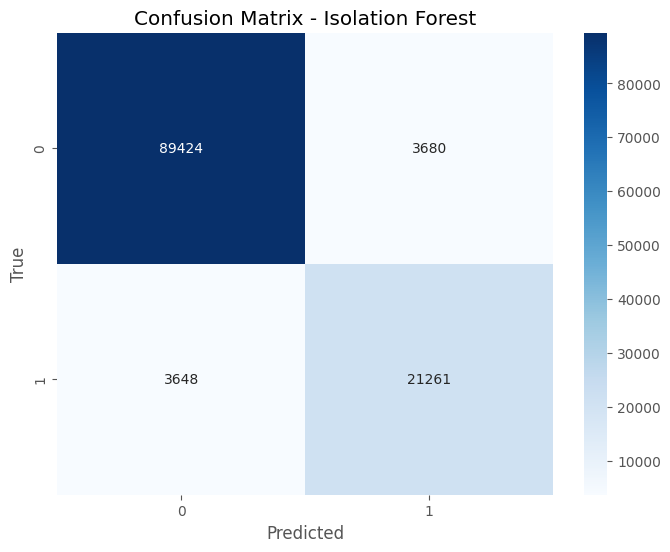

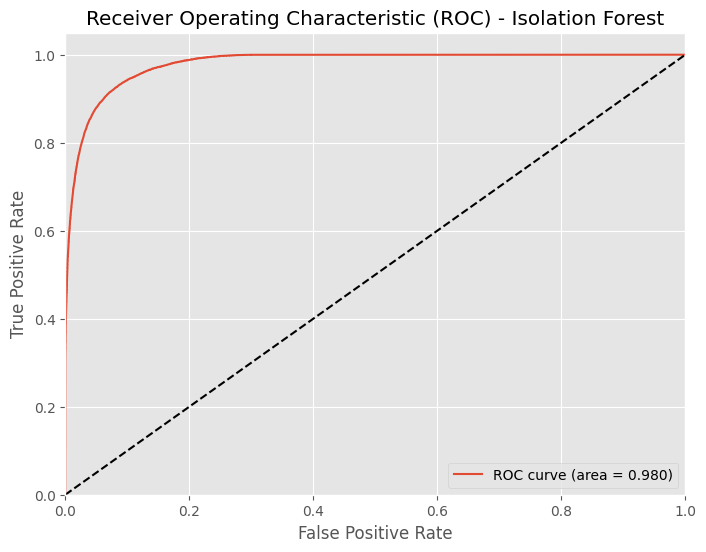

Saving pipeline to rba_universal_isolation_0.9068.pkl...
Pipeline dan scoring info berhasil disimpan!
Model information saved to rba_universal_isolation_0.9068_info.txt

F1-Score (Macro): 0.9068
ROC AUC Score: 0.9798
Training Time: 5.70 seconds
Prediction Time: 6.24 seconds


In [27]:
# Latih dan evaluasi model Isolation Forest dengan pipeline
print("\n===== Evaluasi Model Isolation Forest =====")
isolation_forest_pipeline, isolation_forest_metrics = train_evaluate_isolation_forest_universal(
    X_train, y_train, X_test, y_test, save_model=True
)

print(f"\nF1-Score (Macro): {isolation_forest_metrics['f1_score_macro']:.4f}")
print(f"ROC AUC Score: {isolation_forest_metrics['roc_auc']:.4f}")
print(f"Training Time: {isolation_forest_metrics['training_time']:.2f} seconds")
print(f"Prediction Time: {isolation_forest_metrics['prediction_time']:.2f} seconds")

In [34]:
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score
)

def train_evaluate_lof_universal(X_train, X_test, y_test, contamination=None, save_model=True):
    """
    Melatih model Local Outlier Factor dengan fitur universal (enhanced dengan ensemble)
    + Menghitung dan mem-plot Confusion Matrix serta ROC AUC
    
    Args:
        X_train: DataFrame fitur training
        X_test:  DataFrame fitur testing
        y_test:  Array/Series label sebenarnya untuk testing
        contamination: Perkiraan proporsi anomali; default: mean(y_test)
        save_model: Jika True, simpan model & info ke disk
        
    Returns:
        model_data: dict berisi model, scaler, pca, dll.
        metrics:    dict berisi metrik evaluasi
    """

    
    if contamination is None:
        contamination = float(np.mean(y_test))
    
    # PCA untuk reduksi dimensi
    pca = PCA(n_components=min(5, X_train.shape[1]), random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca  = pca.transform(X_test)
    
    # ————————————————————————————————————————————————
    # 2. Training Phase
    # ————————————————————————————————————————————————
    start_train = time.time()
    
    # 2a. LOF component
    lof_model = LocalOutlierFactor(
        n_neighbors=min(30, len(X_train_pca)//4),
        contamination=contamination,
        novelty=True,
        n_jobs=-1
    )
    lof_model.fit(X_train_pca)
    
    # 2b. Isolation Forest as support
    if_model = IsolationForest(
        n_estimators=50,
        max_samples='auto',
        contamination=contamination,
        random_state=42,
        n_jobs=-1
    )
    if_model.fit(X_train)
    
    training_time = time.time() - start_train

    
    # ————————————————————————————————————————————————
    # 3. Prediction Phase
    # ————————————————————————————————————————————————

    start_pred = time.time()
    
    # LOF
    lof_pred_raw   = lof_model.predict(X_test_pca)
    lof_pred       = np.where(lof_pred_raw == -1, 1, 0)
    lof_scores     = -lof_model.decision_function(X_test_pca)
    
    # IF
    if_pred_raw    = if_model.predict(X_test)
    if_pred        = np.where(if_pred_raw == -1, 1, 0)
    if_scores      = -if_model.decision_function(X_test)
    
    # normalize scores
    scaler_lof = MinMaxScaler()
    scaler_if  = MinMaxScaler()
    
    lof_scores_norm = scaler_lof.fit_transform(lof_scores.reshape(-1,1)).ravel()
    if_scores_norm  = scaler_if.fit_transform(if_scores.reshape(-1,1)).ravel()
    
    # weighted ensemble
    enhanced_scores = 0.65 * lof_scores_norm + 0.35 * if_scores_norm
    
    # thresholding
    thresh = np.percentile(enhanced_scores, (1 - contamination)*100)
    y_pred = (enhanced_scores > thresh).astype(int)
    
    prediction_time = time.time() - start_pred
    print(f" • Prediction done in {prediction_time:.2f}s")
    
    # ————————————————————————————————————————————————
    # 4. Evaluation: Confusion Matrix & ROC AUC
    # ————————————————————————————————————————————————
    # 4a. Hitung metrik
    cm      = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, enhanced_scores)
    f1_mac  = f1_score(y_test, y_pred, average='macro')
    prec    = precision_score(y_test, y_pred)
    rec     = recall_score(y_test, y_pred)
    
    # 4b. Plot Confusion Matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal (0)','Anomaly (1)'],
                yticklabels=['Normal (0)','Anomaly (1)'])
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix - LOF")
    plt.tight_layout()
    plt.show()
    
    # 4c. Plot ROC Curve (opsional, uncomment jika perlu)
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, enhanced_scores)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - LOF")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # ————————————————————————————————————————————————
    # 5. Kumpulkan dan Simpan
    # ————————————————————————————————————————————————
    metrics = {
        'confusion_matrix': cm,
        'roc_auc':           roc_auc,
        'f1_score_macro':   f1_mac,
        'precision':        prec,
        'recall':           rec,
        'training_time_s':  training_time,
        'prediction_time_s':prediction_time
    }
    
    model_data = {
        'lof_model':    lof_model,
        'if_model':     if_model,
        'pca':          pca,
        'scaler_lof':   scaler_lof,
        'scaler_if':    scaler_if,
        'features':     X_train.columns.tolist(),
        'contamination':contamination,
        'metrics':      metrics
    }
    
    if save_model:
        timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
        fname = f"rba_universal_lof_{f1_mac:.4f}_{timestamp}.pkl"
        print(f"💾 Saving model to {fname}...")
        with open(fname, 'wb') as f:
            pickle.dump(model_data, f)
    
    return model_data, metrics

# Contoh panggil:
# model_data, metrics = train_evaluate_lof_universal(X_train, X_test, y_test)
# print(metrics)



===== Evaluasi Model Local Outlier Factor (Fitur Universal) =====
 • Prediction done in 4.83s


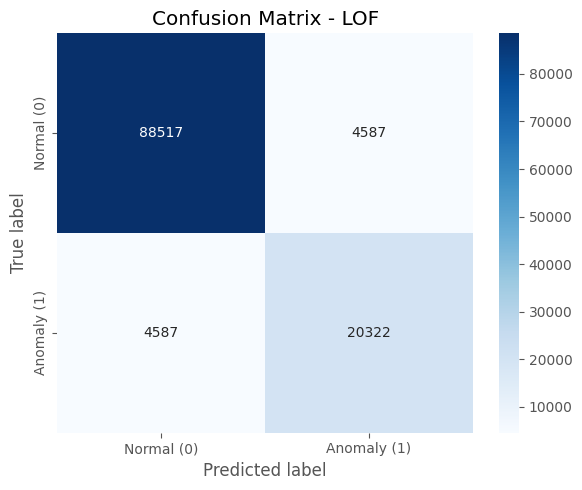

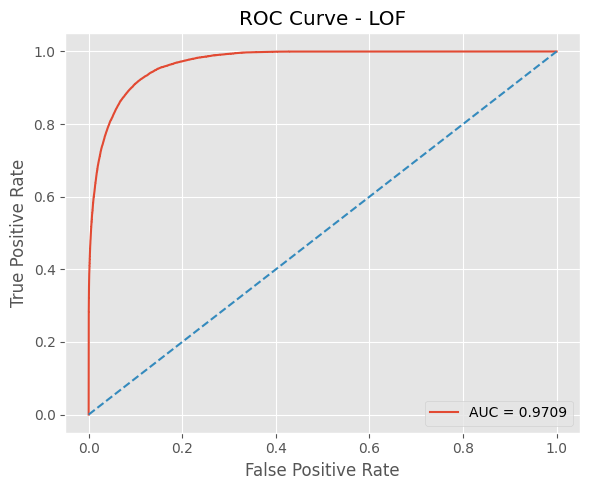

💾 Saving model to rba_universal_lof_0.8833_20250716_183602.pkl...

LOF Results:
F1-Score (Macro): 0.8833
ROC AUC Score: 0.9709


In [35]:
# Latih dan evaluasi model LOF (enhanced) dengan fitur universal
print("\n===== Evaluasi Model Local Outlier Factor (Fitur Universal) =====")
lof_model, lof_metrics = train_evaluate_lof_universal(
    X_train, X_test, y_test, save_model=True
)

print(f"\nLOF Results:")
print(f"F1-Score (Macro): {lof_metrics['f1_score_macro']:.4f}")
print(f"ROC AUC Score: {lof_metrics['roc_auc']:.4f}")

In [36]:
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score
)
from tqdm import tqdm

def train_evaluate_ocsvm_universal(X_train, X_test, y_test, nu=None, save_model=True, already_normalized=True):
    """
    Melatih model One-Class SVM dengan fitur universal (enhanced dengan ensemble)
    + Menghitung dan mem-plot Confusion Matrix serta ROC AUC
    
    Args:
        X_train: Fitur data training
        X_test: Fitur data testing
        y_test: Label sebenarnya untuk data testing
        nu: Parameter nu - upper bound pada fraksi outlier (mirip dengan contamination)
        save_model: Boolean untuk menyimpan model
        already_normalized: Boolean apakah data sudah dinormalisasi sebelumnya
        
    Returns:
        model_data: Model One-Class SVM yang telah dilatih (enhanced)
        metrics: Dictionary berisi metrik evaluasi
    """
    print("Training One-Class SVM model with universal features...")

    # Progress bar
    progress = tqdm(total=100, bar_format="{l_bar}{bar}| {n_fmt}%")
    progress.update(10)

    # Data preparation
    if already_normalized:
        print("Menggunakan data yang sudah dinormalisasi sebelumnya")
        X_train_used = X_train
        X_test_used = X_test
    else:
        print("Melakukan normalisasi data...")
        scaler_base = StandardScaler()
        X_train_used = pd.DataFrame(
            scaler_base.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        X_test_used = pd.DataFrame(
            scaler_base.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
    progress.update(10)

    # Tentukan nu dan contamination
    if nu is None:
        nu = min(0.1, y_test.mean() * 2)
    contamination = y_test.mean()

    progress.update(10)

    # ===== TRAINING PHASE =====
    start_time = time.time()


    ocsvm_model = OneClassSVM(kernel='rbf', gamma='scale', nu=nu, cache_size=500)
    ocsvm_model.fit(X_train_used)
    progress.update(25)
    if_model = IsolationForest(
        n_estimators=50,
        max_samples='auto',
        contamination=contamination,
        random_state=42,
        n_jobs=-1
    )
    if_model.fit(X_train_used)
    progress.update(25)

    training_time = time.time() - start_time
    print(f"Training selesai dalam {training_time:.2f} detik")

    # ===== PREDICTION PHASE =====
    print("Making predictions with OCSVM...")
    start_pred = time.time()

    ocsvm_pred = ocsvm_model.predict(X_test_used)
    ocsvm_pred = np.where(ocsvm_pred == -1, 1, 0)
    ocsvm_scores = -ocsvm_model.decision_function(X_test_used)

    if_pred = if_model.predict(X_test_used)
    if_pred = np.where(if_pred == -1, 1, 0)
    if_scores = -if_model.decision_function(X_test_used)
    progress.update(10)

    scaler_ocsvm = MinMaxScaler()
    scaler_if    = MinMaxScaler()

    ocsvm_scores_norm = scaler_ocsvm.fit_transform(ocsvm_scores.reshape(-1, 1)).flatten()
    if_scores_norm    = scaler_if.fit_transform(if_scores.reshape(-1, 1)).flatten()

    enhanced_scores = 0.70 * ocsvm_scores_norm + 0.30 * if_scores_norm

    threshold = np.percentile(enhanced_scores, (1 - nu) * 100)
    y_pred = (enhanced_scores > threshold).astype(int)

    prediction_time = time.time() - start_pred
    print(f"Prediksi selesai dalam {prediction_time:.2f} detik")
    progress.update(5)

    # ===== EVALUATION =====
    cm      = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, enhanced_scores)
    f1_mac  = f1_score(y_test, y_pred, average='macro')
    prec    = precision_score(y_test, y_pred)
    rec     = recall_score(y_test, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['Normal (0)', 'Anomaly (1)'],
        yticklabels=['Normal (0)', 'Anomaly (1)']
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix - One-Class SVM")
    plt.tight_layout()
    plt.show()

    # (Optional) Plot ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, enhanced_scores)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - One-Class SVM")
    plt.legend()
    plt.tight_layout()
    plt.show()

    progress.update(5)

    metrics = {
        'confusion_matrix': cm,
        'roc_auc':           roc_auc,
        'f1_score_macro':    f1_mac,
        'precision':         prec,
        'recall':            rec,
        'training_time':     training_time,
        'prediction_time':   prediction_time
    }

    model_data = {
        'ocsvm_model':    ocsvm_model,
        'if_model':       if_model,
        'scaler_ocsvm':   scaler_ocsvm,
        'scaler_if':      scaler_if,
        'features':       X_train.columns.tolist(),
        'metrics':        metrics,
        'nu':             nu,
        'contamination':  contamination,
        'normalized':     already_normalized,
        'training_date':  pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    }

    if save_model:
        model_filename = f'rba_universal_ocsvm_normalized_{metrics["f1_score_macro"]:.4f}.pkl'
        print(f"Saving model to {model_filename}...")
        with open(model_filename, 'wb') as f:
            pickle.dump(model_data, f)
        print("OCSVM model berhasil disimpan!")

        model_info_filename = f'rba_universal_ocsvm_normalized_{metrics["f1_score_macro"]:.4f}_info.txt'
        with open(model_info_filename, 'w') as txt:
            txt.write("=== INFORMATION ONE-CLASS SVM MODEL (UNIVERSAL FEATURES) ===\n\n")
            txt.write(f"Model Name: One-Class SVM for Risk-Based Authentication\n")
            txt.write(f"Training Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            txt.write(f"Number of Features: {X_train.shape[1]}\n\n")
            txt.write("Performance Metrics:\n")
            txt.write(f"F1-Score (Macro): {metrics['f1_score_macro']:.4f}\n")
            txt.write(f"ROC AUC: {metrics['roc_auc']:.4f}\n")
            txt.write(f"Training Time: {metrics['training_time']:.2f} seconds\n")
            txt.write(f"Prediction Time: {metrics['prediction_time']:.2f} seconds\n\n")
            txt.write("Model Configuration:\n")
            txt.write(f"Kernel: {ocsvm_model.kernel}\n")
            txt.write(f"Gamma: {ocsvm_model.gamma}\n")
            txt.write(f"Nu: {nu:.4f}\n")
            txt.write(f"Cache Size: {ocsvm_model.cache_size} MB\n\n")
            txt.write("Features Used:\n")
            for feature in X_train.columns:
                txt.write(f"- {feature}\n")
        print(f"Model information saved to {model_info_filename}")

    progress.close()
    return model_data, metrics



===== Evaluasi Model One-Class SVM (Fitur Universal) =====
Training One-Class SVM model with universal features...


  0%|          | 0%

Menggunakan data yang sudah dinormalisasi sebelumnya


 80%|████████  | 80%

Training selesai dalam 3692.32 detik
Making predictions with OCSVM...


 90%|█████████ | 90%

Prediksi selesai dalam 513.20 detik


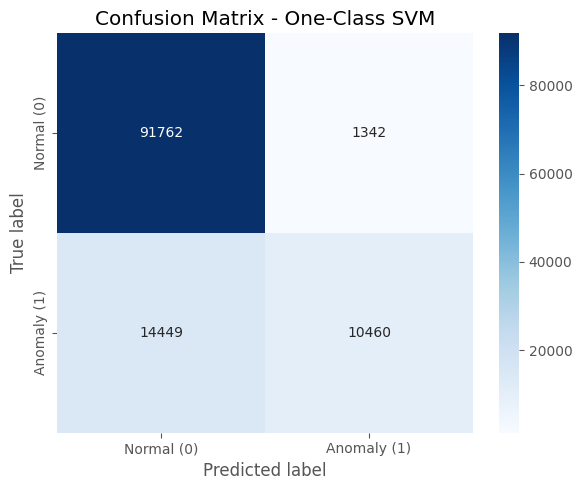

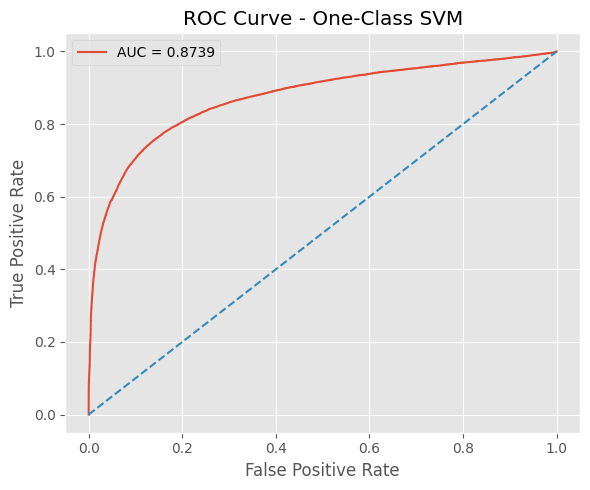

100%|██████████| 100%

Saving model to rba_universal_ocsvm_normalized_0.7453.pkl...
OCSVM model berhasil disimpan!
Model information saved to rba_universal_ocsvm_normalized_0.7453_info.txt

OCSVM Results:
F1-Score (Macro): 0.7453
ROC AUC Score: 0.8739
Training Time: 3692.32 seconds
Prediction Time: 513.20 seconds


In [37]:
# Latih dan evaluasi model OCSVM (enhanced) dengan fitur universal
print("\n===== Evaluasi Model One-Class SVM (Fitur Universal) =====")
ocsvm_model, ocsvm_metrics = train_evaluate_ocsvm_universal(
    X_train, X_test, y_test, save_model=True, already_normalized=True
)

print(f"\nOCSVM Results:")
print(f"F1-Score (Macro): {ocsvm_metrics['f1_score_macro']:.4f}")
print(f"ROC AUC Score: {ocsvm_metrics['roc_auc']:.4f}")
print(f"Training Time: {ocsvm_metrics['training_time']:.2f} seconds")
print(f"Prediction Time: {ocsvm_metrics['prediction_time']:.2f} seconds")

In [42]:
    # Membuat visualisasi perbandingan performa model dengan fitur universal
def compare_models_universal(metrics_dict):
        """
        Membuat visualisasi perbandingan metrik performa model dengan fitur universal
        
        Args:
            metrics_dict: Dictionary dengan nama model sebagai key dan dictionary metrik sebagai value
        """
        # Persiapkan data untuk visualisasi
        models = list(metrics_dict.keys())
        f1_scores = [metrics_dict[model]['f1_score_macro'] for model in models]
        roc_auc_scores = [metrics_dict[model]['roc_auc'] for model in models]

        # Visualisasi F1 Score dan ROC AUC
        plt.figure(figsize=(12, 6))
        
        # Plot F1 Score
        plt.subplot(1, 2, 1)
        bars = plt.bar(models, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        plt.title('F1 Score Comparison')
        plt.ylabel('F1 Score')
        plt.ylim(0, 1)
        
        # Tambahkan nilai di atas bar
        for bar, score in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                    f'{score:.4f}', ha='center', va='bottom')
        
        # Plot ROC AUC
        plt.subplot(1, 2, 2)
        bars = plt.bar(models, roc_auc_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        plt.title('ROC AUC Score Comparison')
        plt.ylabel('ROC AUC')
        plt.ylim(0, 1)
        
        # Tambahkan nilai di atas bar
        for bar, score in zip(bars, roc_auc_scores):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                    f'{score:.4f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('f1_roc_auc_comparison.png')  # Simpan gambar sebagai PNG
        plt.show()
        
        # Tabulasi hasil
        print("\nPerbandingan Performa Model dengan Fitur Universal:")
        print(f"{'Model':<20} {'F1 Score':<20} {'ROC AUC':<15} {'Training Time':<15}")
        print("-" * 70)
        for model in models:
            metrics = metrics_dict[model]
            print(f"{model:<20} {metrics['f1_score_macro']:<20.4f} {metrics['roc_auc']:<15.4f}")

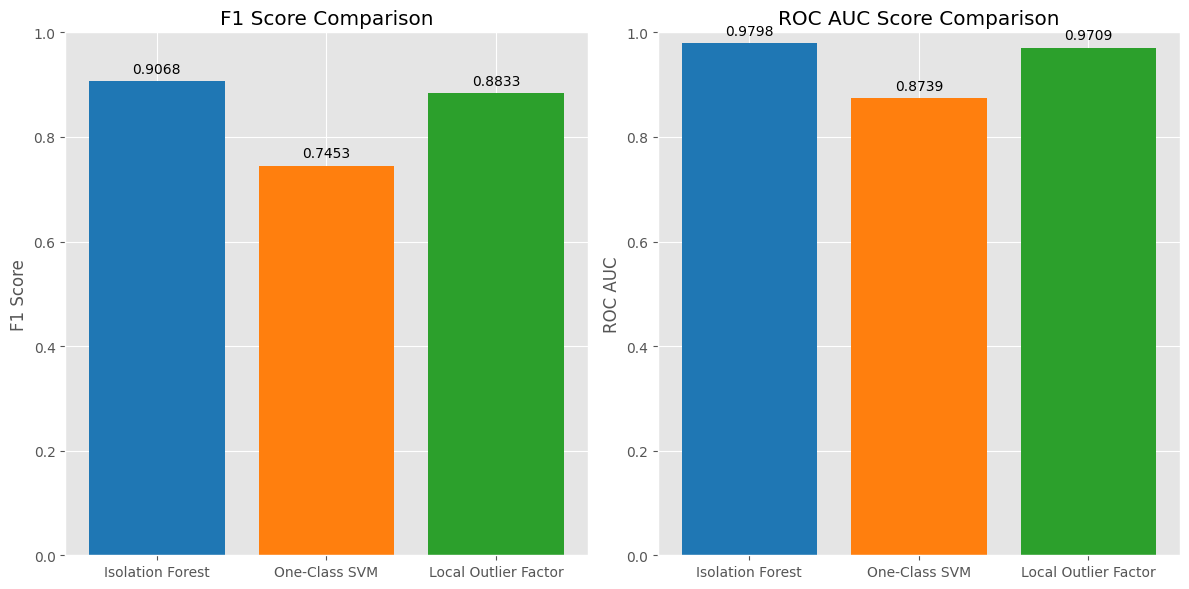


Perbandingan Performa Model dengan Fitur Universal:
Model                F1 Score             ROC AUC         Training Time  
----------------------------------------------------------------------
Isolation Forest     0.9068               0.9798         
One-Class SVM        0.7453               0.8739         
Local Outlier Factor 0.8833               0.9709         


In [43]:
# Kumpulkan metrik dari ketiga model dengan fitur universal
all_metrics_universal = {
    'Isolation Forest': isolation_forest_metrics,
    'One-Class SVM': ocsvm_metrics,
    'Local Outlier Factor': lof_metrics
    
}

# Bandingkan performa ketiga model dengan fitur universal
compare_models_universal(all_metrics_universal)

In [35]:
# Simpan hasil perbandingan ke file
results_filename = 'rba_universal_results_comparison.txt'
with open(results_filename, 'w') as file:
    file.write("PERBANDINGAN HASIL MODEL RBA DENGAN FITUR UNIVERSAL\n")
    file.write("==================================================\n\n")
    
    file.write("Fitur Universal yang Digunakan:\n")
    for feature in universal_features:
        file.write(f"- {feature}\n")
    
    file.write("\nMetrik Performa:\n")
    file.write(f"{'Model':<20} {'F1 Score (Macro)':<20} {'ROC AUC':<15} {'Training Time':<15}\n")
    file.write("-" * 70 + "\n")
    for model in all_metrics_universal:
        metrics = all_metrics_universal[model]
        file.write(f"{model:<20} {metrics['f1_score_macro']:<20.4f} {metrics['roc_auc']:<15.4f} {metrics['training_time']:<15.2f}s\n")
    
    file.write("\nThreshold Information:\n")
    for key, value in thresholds.items():
        file.write(f"{key}: {value:.4f}\n")
    
    file.write("\nDistribusi Risk Level:\n")
    risk_counts = risk_df['risk_level'].value_counts().sort_index()
    risk_percent = risk_df['risk_level'].value_counts(normalize=True).sort_index() * 100
    for level, count in risk_counts.items():
        file.write(f"Risk Level {level}: {count} ({risk_percent[level]:.2f}%)\n")

print(f"Hasil perbandingan disimpan ke {results_filename}")

Hasil perbandingan disimpan ke rba_universal_results_comparison.txt
